# Electric-cars-taxation

This is a Jupyter Notebook for creating insights about the taxation around cars.

## Preprocessing

First we'll get some data from the Statistics of Finland. We start by fetching amounts of newly registered regular gasoline cars.

In [18]:
from requests import post
import pandas as pd

from utils import create_year_list, json_to_text

year_list = create_year_list(1990, 2005)
year_list = list(year_list)

TARGET = './data_files'
# all the relevant data is saved here and gitignored

query_for_90_05 = {
  "query": [
    {
      "code": "Ajoneuvoluokka",
      "selection": {
        "filter": "item",
        "values": [
          "01"
        ]
      }
    },
    {
      "code": "Käyttövoima",
      "selection": {
        "filter": "item",
        "values": [
          "01"
        ]
      }
    },
    {
      "code": "Vuosi",
      "selection": {
        "filter": "item",
        "values": year_list
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


cars_newly_registered_90_05 = post('https://pxdata.stat.fi:443/PxWeb/api/v1/fi/StatFin/merek/statfin_merek_pxt_11ck.px',
                 json=query_for_90_05)
# site url: https://pxdata.stat.fi/PxWeb/pxweb/fi/StatFin/StatFin__merek/statfin_merek_pxt_11ck.px/

if cars_newly_registered_90_05:
    cars_newly_registered_90_05 = cars_newly_registered_90_05.json()

    dest = f'{TARGET}/car_amounts_json.json'

    json_to_text(cars_newly_registered_90_05, dest)
    # read json retrieved from sf to text file to analyze the data to make dataframe efficiently

    years = list(cars_newly_registered_90_05['dimension']['Vuosi']['category']['label'].values())
    amounts = cars_newly_registered_90_05['value']

    registered_df = pd.DataFrame({'Year': years,
                       'Amount': amounts})
    print(registered_df)

JSON data has been successfully written to ./data_files/car_amounts_json.json
    Year  Amount
0   1990  131830
1   1991   87997
2   1992   65095
3   1993   51465
4   1994   63455
5   1995   74386
6   1996   82878
7   1997   89225
8   1998  106025
9   1999  114295
10  2000  108273
11  2001   91412
12  2002   98837
13  2003  125042
14  2004  120536
15  2005  123020


Next we make simple arrow diagram for plotting the data retrieved using seaborn.  

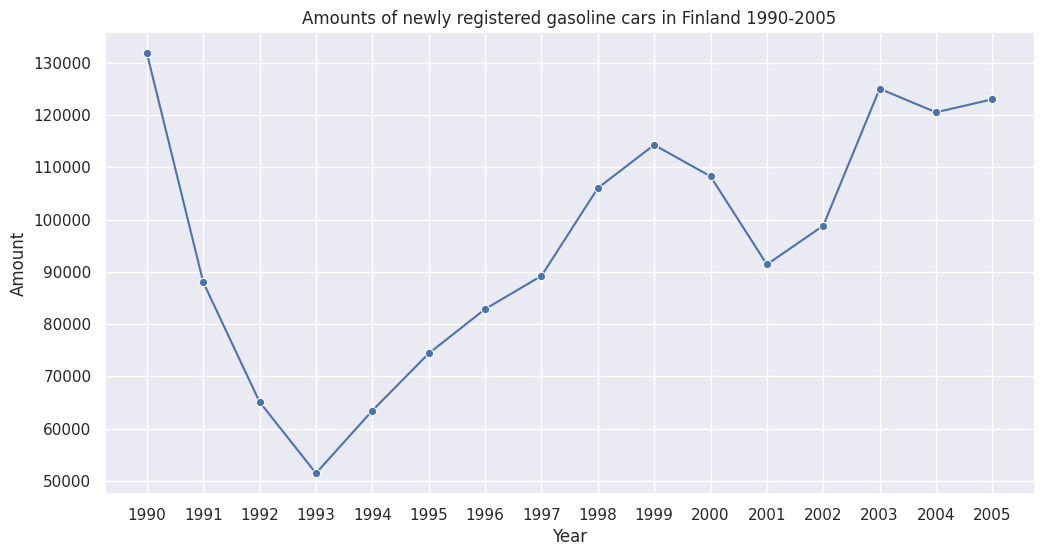

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
plt.figure(figsize=(12, 6))

sns.lineplot(x='Year', y='Amount', data=registered_df, marker='o')

plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Amounts of newly registered gasoline cars in Finland 1990-2005')

plt.show()


JSON data has been successfully written to ./data_files/car_taxes_json.json
    Year  Tax amount (mil)
0   1990               140
1   1991               145
2   1992               137
3   1993               148
4   1994               142
5   1995               112
6   1996               156
7   1997               164
8   1998               175
9   1999               186
10  2000               180
11  2001               209
12  2002               218
13  2003               230
14  2004                 0
15  2005                 0


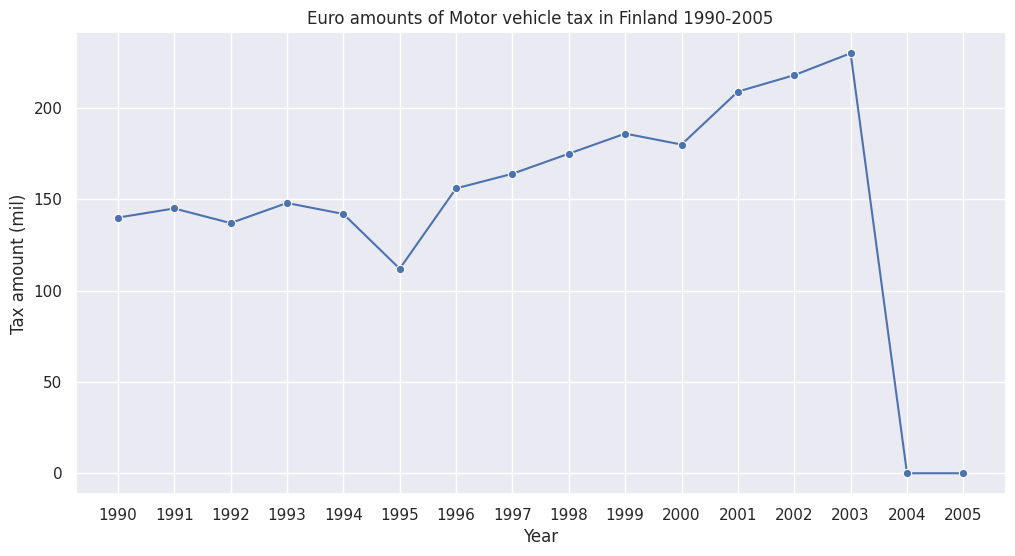

In [20]:
car_tax_json = {
 "query": [
   {
     "code": "Sektori",
     "selection": {
       "filter": "item",
       "values": [
         "S1311"
       ]
     }
   },
   {
     "code": "Verolaji",
     "selection": {
       "filter": "item",
       "values": [
         "521002"
       ]
     }
   },
   {
     "code": "Vuosi",
     "selection": {
       "filter": "item",
       "values": [
         "1990",
         "1991",
         "1992",
         "1993",
         "1994",
         "1995",
         "1996",
         "1997",
         "1998",
         "1999",
         "2000",
         "2001",
         "2002",
         "2003",
         "2004",
         "2005"
       ]
     }
   },
   {
     "code": "Tiedot",
     "selection": {
       "filter": "item",
       "values": [
         "cp"
       ]
     }
   }
 ],
 "response": {
   "format": "json-stat2"
 }
}

cars_taxes_90_05 = post('https://statfin.stat.fi:443/PxWeb/api/v1/fi/StatFin/vermak/statfin_vermak_pxt_127f.px',
                 json=car_tax_json)

if cars_taxes_90_05:
    cars_taxes_90_05 = cars_taxes_90_05.json()

    dest = f'{TARGET}/car_taxes_json.json'

    json_to_text(cars_taxes_90_05, dest)
    # read json retrieved from sf to text file to analyze the data to make dataframe efficiently

    years = list(cars_taxes_90_05['dimension']['Vuosi']['category']['label'].values())
    amounts = cars_taxes_90_05['value']

    taxes_df = pd.DataFrame({'Year': years,
                       'Tax amount (mil)': amounts})
    print(taxes_df)

    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(12, 6))

    sns.lineplot(x='Year', y='Tax amount (mil)', data=taxes_df, marker='o')

    plt.xlabel('Year')
    plt.ylabel('Tax amount (mil)')
    plt.title('Euro amounts of Motor vehicle tax in Finland 1990-2005')

    plt.show()

Combination of the charts:

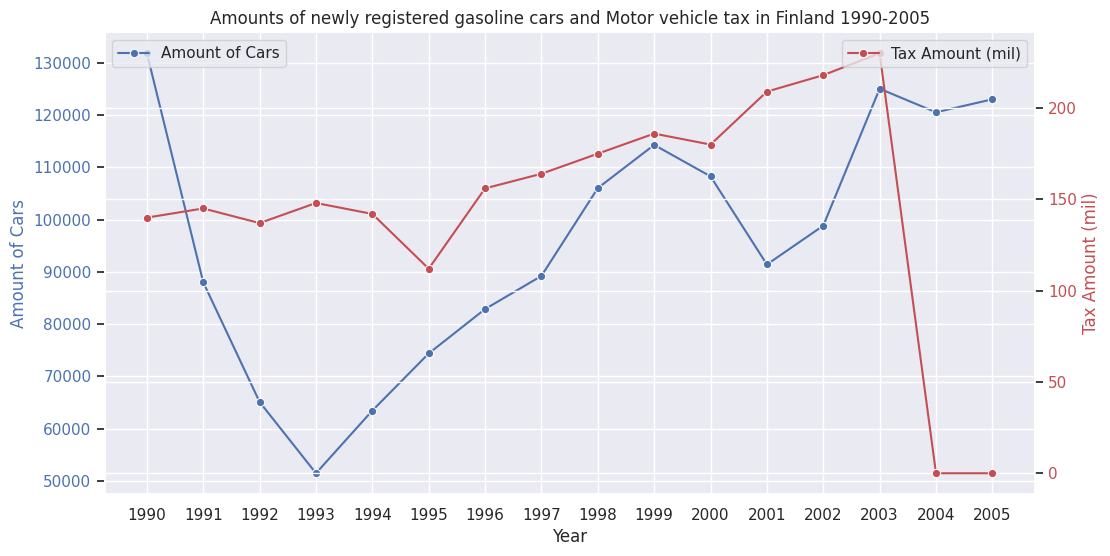

In [21]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 6))

ax1 = plt.gca()
sns.lineplot(x='Year', y='Amount', data=registered_df, marker='o', ax=ax1, color='b', label='Amount of Cars')
ax1.set_xlabel('Year')
ax1.set_ylabel('Amount of Cars', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
sns.lineplot(x='Year', y='Tax amount (mil)', data=taxes_df, marker='o', ax=ax2, color='r', label='Tax Amount (mil)')
ax2.set_ylabel('Tax Amount (mil)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Amounts of newly registered gasoline cars and Motor vehicle tax in Finland 1990-2005')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()